In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

!ls "/content/drive/My Drive/MiniProject_3_551"

Mounted at /content/drive/
aclImdb  aclImdb_v1.tar.gz


In [ ]:
import os
import numpy as np
import re
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, accuracy_score, precision_score, recall_score, f1_score
import tarfile
import pandas as pd
import seaborn as sns
from scipy import stats
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

# 1. Data Preperation

In [ ]:
#tar_file_path = '/content/drive/My Drive/MiniProject_3_551/aclImdb_v1.tar'
output_dir = '/content/drive/My Drive/MiniProject_3_551/aclImdb'

#with tarfile.open(tar_file_path, 'r') as tar:
  #tar.extractall(path=output_dir)

In [ ]:
testpath = os.path.join(output_dir, 'aclImdb/test')
!ls "/content/drive/My Drive/MiniProject_3_551/aclImdb/aclImdb/test"
trainpath = os.path.join(output_dir, 'aclImdb/train')
!ls "/content/drive/My Drive/MiniProject_3_551/aclImdb/aclImdb/train"

labeledBow.feat  neg  pos  urls_neg.txt  urls_pos.txt
labeledBow.feat  pos	unsupBow.feat  urls_pos.txt
neg		 unsup	urls_neg.txt   urls_unsup.txt


# 2. Model Implementations

## Data Processing for Naive Bayes Model

In [ ]:
def tokenize(text):
    tokens = nltk.word_tokenize(text)
    lemmatizer = WordNetLemmatizer()

    preprocessed = []
    for t in tokens:
      if t.isalpha():
        preprocessed.append(lemmatizer.lemmatize(t.lower()))
    return preprocessed

def load_data(path):
    texts = []
    labels = []
    for label in ('pos', 'neg'):
        for file_name in os.listdir(os.path.join(path, label)):
            with open(os.path.join(os.path.join(path, label), file_name), 'r', encoding='utf-8') as file:
                text = file.read()
                tokens = tokenize(text)
                texts.append(" ".join(tokens))
                if label == 'pos':
                  labels.append(1)
                else:
                  labels.append(0)
    return texts, np.array(labels)

train_texts, train_labels = load_data(testpath)
test_texts, test_labels = load_data(trainpath)

## 2.1 Multinomial Naive Bayes Implementation

In [ ]:
class MultinomialNaiveBayes:

    def __init__(self, alpha=1.0):
        self.alpha = alpha #laplace smoothing for missing words (0 probs)

    def fit(self, x, y):
        N, D = x.shape #N samples, D features (words)
        C = np.max(y) + 1 #2 classes
        count_matrix = np.zeros((C, D))
        class_counts = np.zeros(C)

        #counting samples for each classs and storing sums
        for c in range(C):
            x_c = x[y == c]
            class_counts[c] = x_c.shape[0]
            count_matrix[c, :] = np.sum(x_c, axis=0)

        self.log_likelihood = np.log((count_matrix + self.alpha) / (np.sum(count_matrix, axis=1)[:, None] + self.alpha * D))
        self.log_prior = np.log((class_counts + self.alpha) / (N + self.alpha * C))
        return self

    #predict calculates log post probs for each class and sample
    #returns class with highest logpostprob
    def predict(self, xt):
        log_posterior = self.log_prior[:, None] + np.dot(self.log_likelihood, xt.T)
        return np.argmax(log_posterior, axis=0)

    #finding prop of predictions made correctly
    def evaluate_acc(self, y_true, y_pred):
        return np.mean(y_true == y_pred)


### 2.1.1 Feature Size Testing

In [ ]:
feat_sizes = [500, 750, 1000, 2500, 5000, 7500, 10000, 15000]

for f in feat_sizes:
    vectorizer = CountVectorizer(stop_words='english', max_features=f)
    train_features = vectorizer.fit_transform(train_texts).toarray()
    test_features = vectorizer.transform(test_texts).toarray()

    NB_model = MultinomialNaiveBayes(alpha=1.0)
    NB_model.fit(train_features, train_labels)
    predictions = NB_model.predict(test_features)
    accuracy = NB_model.evaluate_acc(test_labels, predictions)
    print(f"Accuracy with {f} features: {accuracy}")

### Evaluate baseline performance of Naive Bayes model

Naive Bayes Model
Accuracy: 0.83316
Precision: 0.8377808419174304
Recall: 0.82632
F1 score: 0.8320109549317332


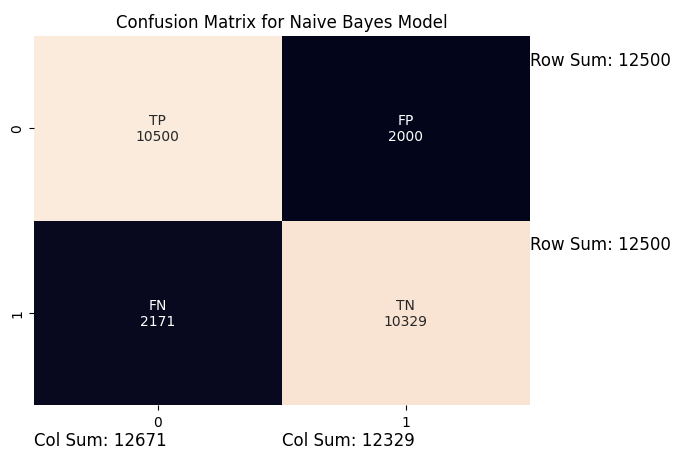

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
NB_train_features = vectorizer.fit_transform(train_texts).toarray()
NB_test_features = vectorizer.transform(test_texts).toarray()

NB_model = MultinomialNaiveBayes(alpha=1.0)
NB_model.fit(NB_train_features, train_labels)
NB_predictions = NB_model.predict(NB_test_features)

print('Naive Bayes Model')
print('Accuracy:', NB_model.evaluate_acc(test_labels, NB_predictions))
print('Precision:', precision_score(test_labels, NB_predictions))
print('Recall:', recall_score(test_labels, NB_predictions))
print('F1 score:', f1_score(test_labels, NB_predictions))

cmatrix = confusion_matrix(test_labels, NB_predictions)
hm = sns.heatmap(cmatrix, annot=True, fmt='d', cbar=False)
for t, cell in zip(["TP", "FP", "FN", "TN"], hm.texts):
        cell.set_text(f"{t}\n{cell.get_text()}")


row_sums = np.sum(cmatrix, axis=1)
col_sums = np.sum(cmatrix, axis=0)
for i, (row_sum, col_sum) in enumerate(zip(row_sums, col_sums)):
    hm.text(2, i, f"\n\nRow Sum: {row_sum}", ha='left', va='center_baseline', color='black', fontsize=12)
    hm.text(i, 2, f"\n\n\nCol Sum: {col_sum}", ha='left', va='center_baseline', color='black', fontsize=12)

plt.title('Confusion Matrix for Naive Bayes Model')
plt.show()

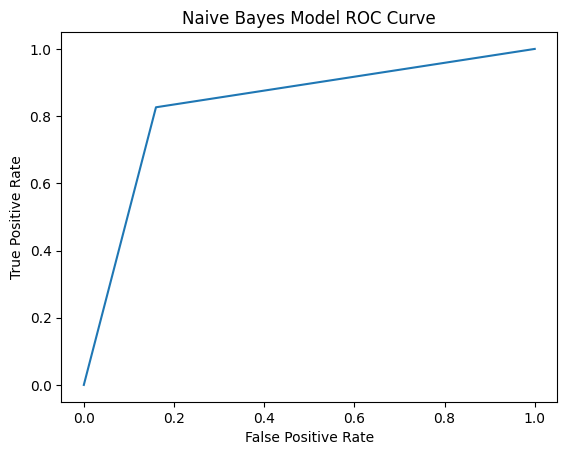

In [ ]:
# Plot ROC curve
NB_fpr, NB_tpr, _ = roc_curve(test_labels,  NB_predictions)
plt.plot(NB_fpr,NB_tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Naive Bayes Model ROC Curve')
plt.show()

### 2.1.2 Laplace Smoothing Tuning

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=5000)
train_features = vectorizer.fit_transform(train_texts).toarray()
test_features = vectorizer.transform(test_texts).toarray()

alphas = [0.01, 0.1, 0.5, 1.0]

for a in alphas:
    NB_laplace_model = MultinomialNaiveBayes(a)
    NB_laplace_model.fit(train_features, train_labels)
    NB_laplace_predictions = NB_laplace_model.predict(test_features)
    accuracy = NB_laplace_model.evaluate_acc(test_labels, NB_laplace_predictions)
    print(f"Accuracy with alpha {a}: {accuracy}")

### 2.1.3 Experimenting with N-grams

In [ ]:
ngrams = [(1, 1), (1, 2), (1, 3)]

for ng in ngrams:
    vectorizer = CountVectorizer(stop_words='english', max_features=5000, ngram_range=ng)
    NB_ngram_train_features = vectorizer.fit_transform(train_texts).toarray()
    NB_ngram_test_features = vectorizer.transform(test_texts).toarray()

    NB_ngram_model = MultinomialNaiveBayes(alpha=.1)
    NB_ngram_model.fit(NB_ngram_train_features, train_labels)
    NB_ngram_predictions = NB_ngram_model.predict(NB_ngram_test_features)
    accuracy = NB_ngram_model.evaluate_acc(test_labels, NB_ngram_predictions)
    print(f"Accuracy with ngram_range {ng}: {accuracy}")

### 2.1.4 TF-IDF representation vs BoW representation

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
NB_TF_IDF_train_features = vectorizer.fit_transform(train_texts).toarray()
NB_TF_IDF_test_features = vectorizer.transform(test_texts).toarray()

NB_TF_IDF_model = MultinomialNaiveBayes(alpha=.1)
NB_TF_IDF_model.fit(NB_TF_IDF_train_features, train_labels)
NB_TF_IDF_predictions = NB_TF_IDF_model.predict(NB_TF_IDF_test_features)
accuracy = NB_TF_IDF_model.evaluate_acc(test_labels, NB_TF_IDF_predictions)
print(f"Accuracy with TF-IDF features: {accuracy}")

Accuracy with TF-IDF features: 0.84552


### Removing correlated features with ANOVA filtering

In [ ]:
vectorizer = CountVectorizer(stop_words='english', max_features=5000, ngram_range=(1,2))
NB_train_features = vectorizer.fit_transform(train_texts).toarray()
NB_test_features = vectorizer.transform(test_texts).toarray()

# Convert to pandas dataframes
x_train = pd.DataFrame(NB_train_features)
x_test = pd.DataFrame(NB_test_features)
y_train = pd.DataFrame(train_labels)
y_test = pd.DataFrame(test_labels)

# Identify the 1000 least correlated and most variable features using F-test
best_feats = SelectKBest(score_func=f_regression, k=1000)
fit = best_feats.fit(x_train, y_train.values.ravel())
feat_scores = pd.DataFrame(fit.scores_, columns=['F_Score'])
reduced_feats = feat_scores.nlargest(1000,columns="F_Score")

# Select only the 1000 best features
reduced_x_train = np.array(x_train.iloc[:, reduced_feats.index])
reduced_x_test = np.array(x_test.iloc[:, reduced_feats.index])

# Train multinomial Naive Bayes Model using the identified 1000 best features
NB_anova_model = MultinomialNaiveBayes(alpha=.1)
NB_anova_model.fit(reduced_x_train, train_labels)
NB_anova_predictions = NB_anova_model.predict(reduced_x_test)
accuracy = NB_anova_model.evaluate_acc(test_labels, NB_anova_predictions)
print(f"Test Accuracy: {accuracy}")

Test Accuracy: 0.85456
ANOVA Tf-IDF Naive Bayes Model
Accuracy: 0.85456
Precision: 0.8432465923172243
Recall: 0.87104
F1 score: 0.8569179915000787


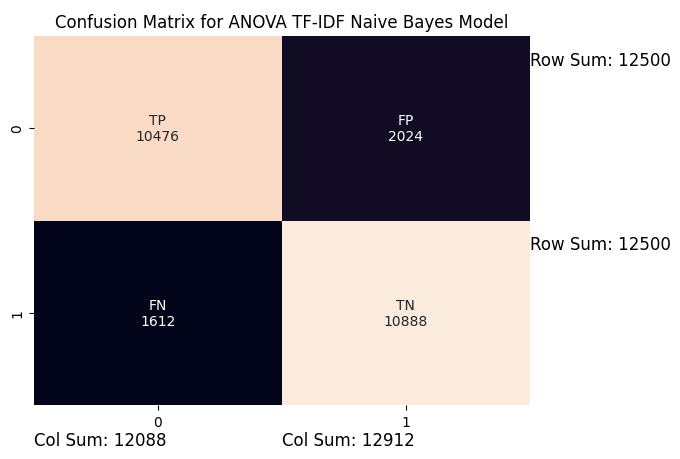

In [ ]:
# Convert to pandas dataframes
x_train = pd.DataFrame(NB_TF_IDF_train_features)
x_test = pd.DataFrame(NB_TF_IDF_test_features)
y_train = pd.DataFrame(train_labels)
y_test = pd.DataFrame(test_labels)

# Identify the 1000 least correlated and most variable features using F-test
best_feats = SelectKBest(score_func=f_regression, k=1000)
fit = best_feats.fit(x_train, y_train.values.ravel())
feat_scores = pd.DataFrame(fit.scores_, columns=['F_Score'])
reduced_feats = feat_scores.nlargest(1000,columns="F_Score")

# Select only the 1000 best features
reduced_x_train = np.array(x_train.iloc[:, reduced_feats.index])
reduced_x_test = np.array(x_test.iloc[:, reduced_feats.index])

# Train multinomial Naive Bayes Model using the identified 1000 best features
NB_anova_tfidf_model = MultinomialNaiveBayes(alpha=.1)
NB_anova_tfidf_model.fit(reduced_x_train, train_labels)
NB_anova_tfidf_predictions = NB_anova_tfidf_model.predict(reduced_x_test)
accuracy = NB_anova_tfidf_model.evaluate_acc(test_labels, NB_anova_tfidf_predictions)
print(f"Test Accuracy: {accuracy}")

print('ANOVA Tf-IDF Naive Bayes Model')
print('Accuracy:', accuracy)
print('Precision:', precision_score(test_labels, NB_anova_tfidf_predictions))
print('Recall:', recall_score(test_labels, NB_anova_tfidf_predictions))
print('F1 score:', f1_score(test_labels, NB_anova_tfidf_predictions))

cmatrix = confusion_matrix(test_labels, NB_anova_tfidf_predictions)
hm = sns.heatmap(cmatrix, annot=True, fmt='d', cbar=False)
for t, cell in zip(["TP", "FP", "FN", "TN"], hm.texts):
        cell.set_text(f"{t}\n{cell.get_text()}")


row_sums = np.sum(cmatrix, axis=1)
col_sums = np.sum(cmatrix, axis=0)
for i, (row_sum, col_sum) in enumerate(zip(row_sums, col_sums)):
    hm.text(2, i, f"\n\nRow Sum: {row_sum}", ha='left', va='center_baseline', color='black', fontsize=12)
    hm.text(i, 2, f"\n\n\nCol Sum: {col_sum}", ha='left', va='center_baseline', color='black', fontsize=12)

plt.title('Confusion Matrix for ANOVA TF-IDF Naive Bayes Model')
plt.show()

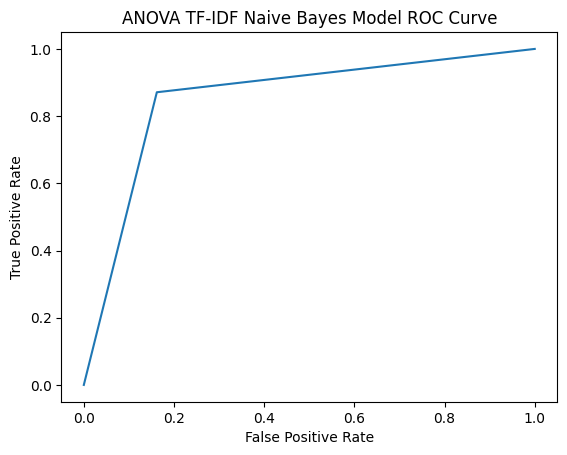

In [ ]:
# Plot ROC curve
NB_anova_tfidf_fpr, NB_anova_tfidf_tpr, _ = roc_curve(test_labels,  NB_anova_tfidf_predictions)
plt.plot(NB_anova_tfidf_fpr, NB_anova_tfidf_tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ANOVA TF-IDF Naive Bayes Model ROC Curve')
plt.show()

## 2.2 BERT Model with Pre-trained Weights

In [ ]:
def load_data_bert(path):
    texts = []
    labels = []
    for label in ('pos', 'neg'):
        for file_name in os.listdir(os.path.join(path, label)):
            with open(os.path.join(os.path.join(path, label), file_name), 'r', encoding='utf-8') as file:
                texts.append(file.read())
                if label == 'pos':
                  labels.append(1)
                else:
                  labels.append(0)
    return texts, np.array(labels)

train_texts_bert, train_labels_bert = load_data_bert(testpath)
test_texts_bert, test_labels_bert = load_data_bert(trainpath)

Pre-Processing data for BERT

In [ ]:
!pip install transformers datasets
!pip install tqdm boto3 requests regex sentencepiece sacremoses

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.0/7.0 MB 60.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.7/468.7 kB 54.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 74.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 28.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 17.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.9/132.9 kB 20.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 79.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 29.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.2/114.2 kB 18.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 kB 34.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 158.8/158.8 kB 23.1 MB/s eta 0:00:00
Looking in index

## BERT with Hyper-Parameter tuning


In [ ]:
import torch
import numpy as np
import os
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from itertools import product

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
model.to(device)

train_encodings = tokenizer(train_texts_bert, padding=True, truncation=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(test_texts_bert, padding=True, truncation=True, max_length=256, return_tensors="pt")
train_labels = torch.tensor(train_labels_bert)
test_labels = torch.tensor(test_labels_bert)

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels_bert)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels_bert)

# define grid search hyperparameters
param_grid = {
    'batch_size': [1, 2, 3],
    'learning_rate': [1e-5, 2e-5, 1e-4],
}

# generate all possible combinations of hyperparameters
param_combinations = list(product(*param_grid.values()))

best_acc = 0

for params in param_combinations:
    batch_size, learning_rate = params

    # set hyperparameters
    train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
    test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # train model
    for epoch in range(2):
        model.train()
        for batch in train_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            optimizer.zero_grad()
            outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss
            logits = outputs.logits
            loss.backward()
            optimizer.step()

    # evaluate model
    model.eval()
    predictions = []
    true_labels = []
    with torch.no_grad():
        for batch in test_dataloader:
            batch = tuple(t.to(device) for t in batch)
            input_ids, attention_mask, labels = batch
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
            true_labels.extend(labels.cpu().numpy())

    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)

    # Save best performing model and predictions
    if accuracy > best_acc:
      best_acc = accuracy
      BERT_model = model
      BERT_predictions = predictions

    # print results
    print(f"Batch size: {batch_size}, Learning rate: {learning_rate}")
    print("Accuracy:", accuracy)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1-Score:", f1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Batch size: 1, Learning rate: 1e-05
Accuracy: 0.9108
Precision: 0.9131799163179917
Recall: 0.90792
F1-Score: 0.9105423620025676


## BERT with Fine-Tuning



In [ ]:
import torch
import numpy as np
import os
from transformers import BertTokenizer, BertForSequenceClassification
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
ft_bert_model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
ft_bert_model.to(device)

train_encodings = tokenizer(train_texts_bert, padding=True, truncation=True, max_length=256, return_tensors="pt")
test_encodings = tokenizer(test_texts_bert, padding=True, truncation=True, max_length=256, return_tensors="pt")
train_labels_bert = torch.tensor(train_labels_bert)
test_labels_bert = torch.tensor(test_labels_bert)

train_dataset = TensorDataset(train_encodings["input_ids"], train_encodings["attention_mask"], train_labels_bert)
test_dataset = TensorDataset(test_encodings["input_ids"], test_encodings["attention_mask"], test_labels_bert)

batch_size = 3
learning_rate = 1e-5
train_dataloader = DataLoader(train_dataset, sampler=RandomSampler(train_dataset), batch_size=batch_size)
test_dataloader = DataLoader(test_dataset, sampler=SequentialSampler(test_dataset), batch_size=batch_size)
optimizer = torch.optim.Adam(ft_bert_model.parameters(), lr=learning_rate)

epochs = 2
for epoch in range(epochs):
    ft_bert_model.train()
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        optimizer.zero_grad()
        outputs = ft_bert_model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        logits = outputs.logits
        loss.backward()
        optimizer.step()
    print("Epoch:", epoch+1)

ft_bert_model.eval()
ft_bert_predictions = []
ft_bert_test_labels = []
with torch.no_grad():
    for batch in test_dataloader:
        batch = tuple(t.to(device) for t in batch)
        input_ids, attention_mask, labels = batch
        outputs = ft_bert_model(input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        ft_bert_predictions.extend(torch.argmax(logits, axis=1).cpu().numpy())
        ft_bert_test_labels.extend(labels.cpu().numpy())

accuracy = accuracy_score(ft_bert_test_labels, ft_bert_predictions)
precision = precision_score(ft_bert_test_labels, ft_bert_predictions)
recall = recall_score(ft_bert_test_labels, ft_bert_predictions)
f1 = f1_score(ft_bert_test_labels, ft_bert_predictions)

print("Fine-tuned BERT model")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

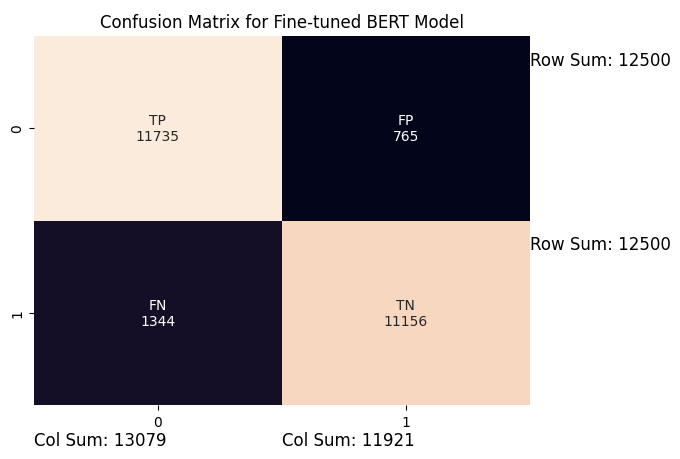

In [ ]:
# Confusion matrix
cmatrix = confusion_matrix(ft_bert_test_labels, ft_bert_predictions)
hm = sns.heatmap(cmatrix, annot=True, fmt='d', cbar=False)
for t, cell in zip(["TP", "FP", "FN", "TN"], hm.texts):
        cell.set_text(f"{t}\n{cell.get_text()}")


row_sums = np.sum(cmatrix, axis=1)
col_sums = np.sum(cmatrix, axis=0)
for i, (row_sum, col_sum) in enumerate(zip(row_sums, col_sums)):
    hm.text(2, i, f"\n\nRow Sum: {row_sum}", ha='left', va='center_baseline', color='black', fontsize=12)
    hm.text(i, 2, f"\n\n\nCol Sum: {col_sum}", ha='left', va='center_baseline', color='black', fontsize=12)

plt.title('Confusion Matrix for Fine-tuned BERT Model')
plt.show()

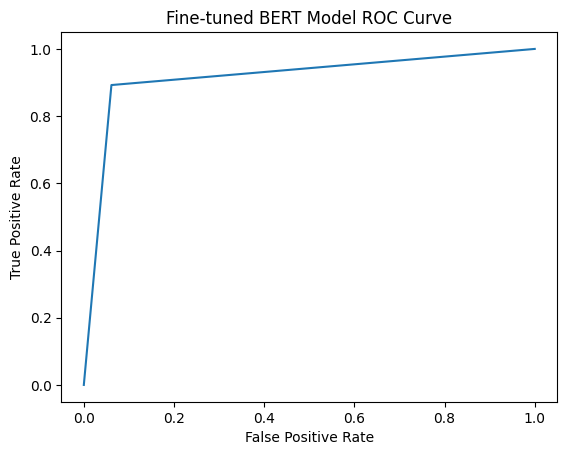

In [ ]:
# Plot ROC curve
ft_bert_fpr, ft_bert_tpr, _ = roc_curve(ft_bert_test_labels,  ft_bert_predictions)
plt.plot(ft_bert_fpr, ft_bert_tpr)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('Fine-tuned BERT Model ROC Curve')
plt.show()

## 3.2 Examining the attention matrix between word and class tokens

In [ ]:
!pip install bertviz
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 157.6/157.6 kB 2.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

Example 0: predicted correctly


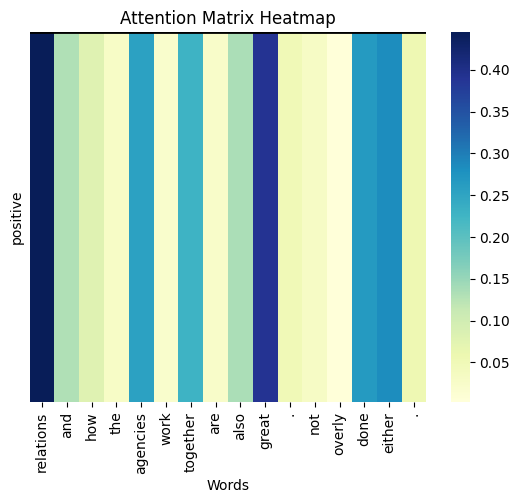

Example 1: predicted incorrectly


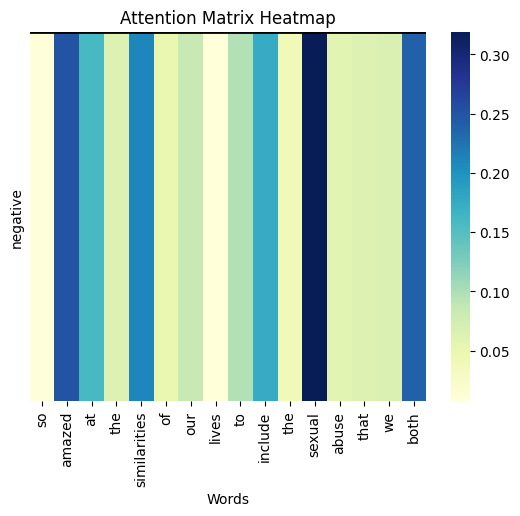

Example 2: predicted incorrectly


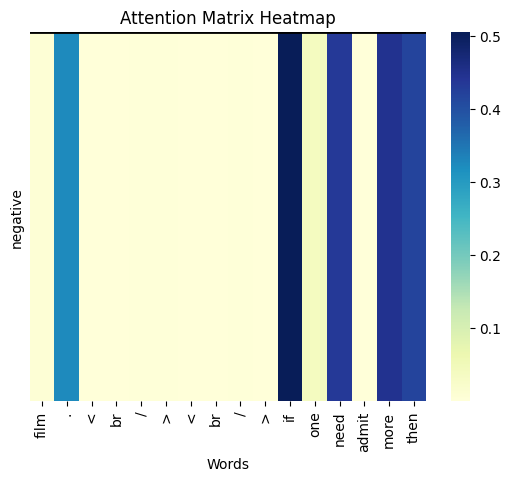

Example 3: predicted incorrectly


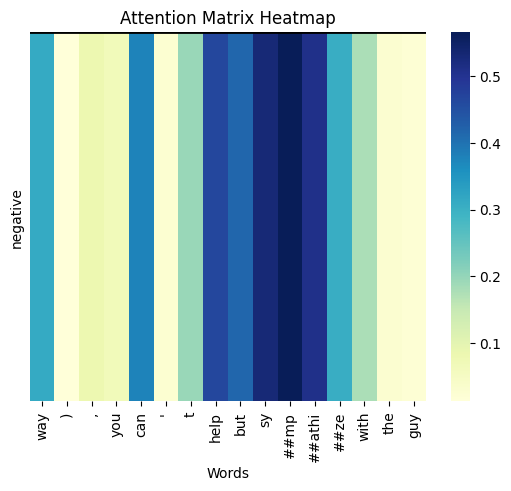

Example 4: predicted incorrectly


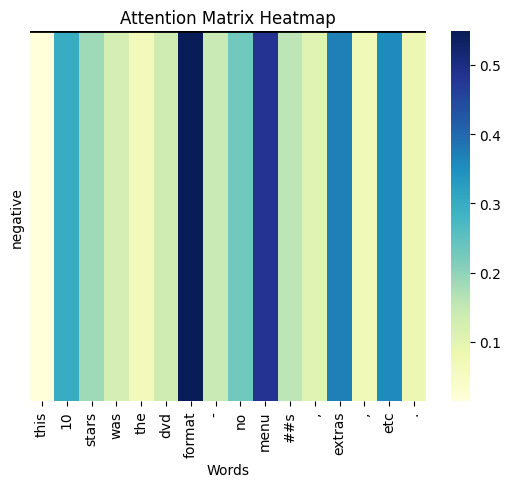

Example 5: predicted correctly


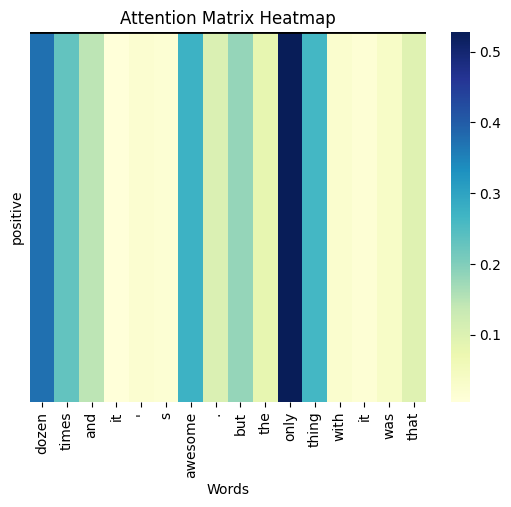

Example 6: predicted correctly


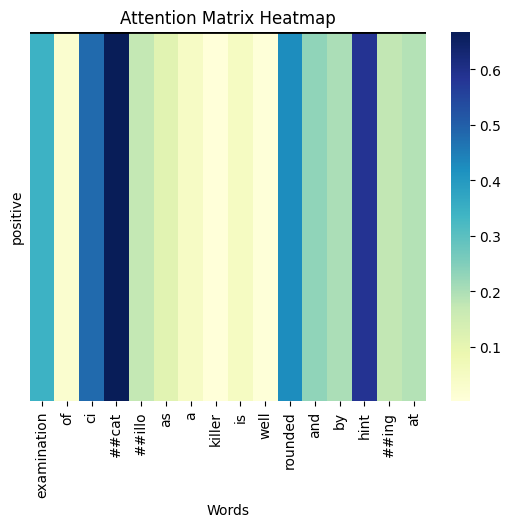

Example 7: predicted incorrectly


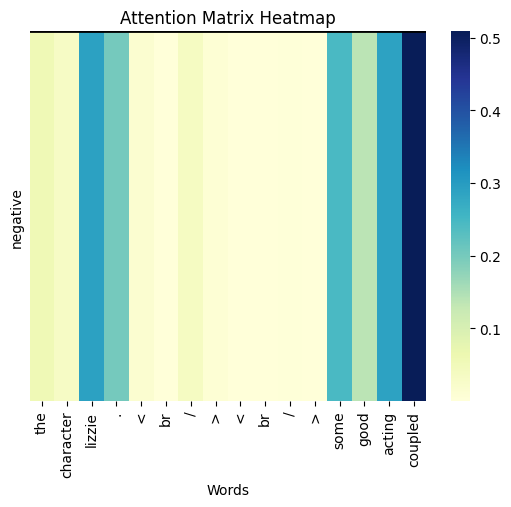

Example 8: predicted incorrectly


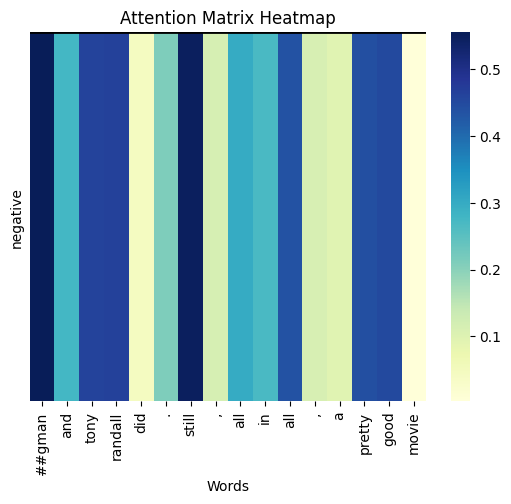

Example 9: predicted incorrectly


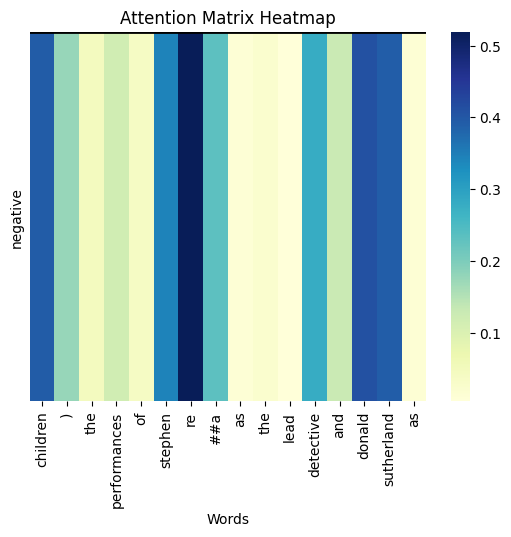

In [ ]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification
import random

model = BertForSequenceClassification.from_pretrained('bert-base-uncased', output_attentions=True, output_hidden_states=True)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
test_encodings = tokenizer(test_texts_bert, padding=True, truncation=True, max_length=256, return_tensors="pt").to(device)
test_labels = torch.tensor(test_labels_bert).to(device)

block = 3
head = 0
labels = ["negative", "positive"]

# Set the model to evaluation mode and disable gradient computation
with torch.no_grad():
    model.eval()

    # Loop over a few examples
    for i in range(10):

        # Get the input text and label
        input_text = test_texts_bert[i]
        true_label = test_labels[i]

        # Convert the input text to tokens
        input_ids = tokenizer.encode(input_text, add_special_tokens=True, return_tensors="pt").to(device)
        tokens = tokenizer.convert_ids_to_tokens(input_ids[0])

        # Get the predicted label and attention weights
        outputs = model(input_ids)
        predicted_label = torch.argmax(outputs[0]).item()
        attention_weights = outputs[-1][block][head][0]

        # Check if the prediction is correct
        if predicted_label == true_label:
            print(f"Example {i}: predicted correctly")
        else:
            print(f"Example {i}: predicted incorrectly")

        # Extract the attention weights corresponding to the class token
        class_token_weights = attention_weights[0]

        # Remove the attention weight corresponding to the class token
        attention_weights = attention_weights[1:]
        tokens = tokens[1:]

        # Choose a random subset of tokens to display
        start_idx = random.randint(0, len(tokens)-16)
        end_idx = start_idx + 16
        subset_weights = attention_weights[start_idx:end_idx, 0].cpu().numpy()
        subset_tokens = tokens[start_idx:end_idx]

        # Create the heatmap using attention_weights
        ax = sns.heatmap(subset_weights.reshape(1,-1), cmap="YlGnBu", annot=False, xticklabels=subset_tokens, yticklabels=False)

        # Add the row for the class token
        ax.axhline(y=0, color='k',linewidth=2)

        # Set the heatmap properties
        ax.set_title('Attention Matrix Heatmap')
        ax.set_xlabel('Words')
        ax.set_ylabel(labels[predicted_label])

        plt.show()

